# Imports

In [1]:
import pandas as pd
import numpy as np
import requests
from pybaseball import statcast_batter, playerid_lookup
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import time
from datetime import datetime, timedelta

# Team Abbreviation Mapping to Team ID

In [2]:
def get_team_id_map():
    url = "https://statsapi.mlb.com/api/v1/teams?sportId=1"
    response = requests.get(url)
    data = response.json()
    return {team['abbreviation']: team['id'] for team in data['teams']}

# Get active roster
Get's the list of players playing

In [3]:
def get_roster(team_abbr, team_id_map=None):
    if team_id_map is None:
        team_id_map = get_team_id_map()
    team_id = team_id_map.get(team_abbr.upper())
    if not team_id:
        raise ValueError(f"Invalid team abbreviation: {team_abbr}")
    url = f"https://statsapi.mlb.com/api/v1/teams/{team_id}/roster/active"
    response = requests.get(url)
    return [player['person']['fullName'] for player in response.json()['roster']]

# Estimate Spray Angle

In [4]:
def estimate_spray_angle(df):
    return np.degrees(np.arctan2(df['hc_x'] - 125, 198 - df['hc_y']))

# Predict Homerun Landing

In [5]:
def predict_landing_point(launch_speed, launch_angle, spray_angle, distance=None):
    angle_rad = np.radians(spray_angle)

    if distance is None or pd.isna(distance):
        v = launch_speed * 0.44704  # mph to m/s
        theta = np.radians(launch_angle)
        g = 9.81
        range_1D = (v ** 2 * np.sin(2 * theta)) / g
        distance = range_1D * 3.28084

    distance = max(min(distance, 470), 290)

    x = distance * np.sin(angle_rad)
    y = distance * np.cos(angle_rad)
    return x, y

# Get all HR's from a team

In [6]:
def get_team_home_runs(team_abbr, start=None, end=None):
    if end is None:
        end = datetime.today().strftime('%Y-%m-%d')
    if start is None:
        start = (datetime.today() - timedelta(days=365)).strftime('%Y-%m-%d')
    
    team_id_map = get_team_id_map()
    roster = get_roster(team_abbr, team_id_map)
    all_hr_rows = []

    for name in roster:
        try:
            first, last = name.split()[-2:]
            pid_df = playerid_lookup(last, first)
            if pid_df.empty:
                continue
            pid = pid_df.iloc[0]['key_mlbam']
            df = statcast_batter(start, end, player_id=pid)
            df = df[df['events'] == 'home_run'].dropna(subset=['launch_speed', 'launch_angle', 'hc_x', 'hc_y']).copy()
            if df.empty:
                continue
            df['player_name'] = name
            df['spray_angle_est'] = estimate_spray_angle(df)
            all_hr_rows.append(df)
            time.sleep(0.5)
        except Exception as e:
            print(f"Skipping {name}: {e}")
            continue

    if all_hr_rows:
        return pd.concat(all_hr_rows, ignore_index=True)
    return pd.DataFrame()

# Stadium Diagrams
From Andrew Clem's website

In [7]:
def get_stadium_image_url(stadium_name):
    clean_name = stadium_name.replace(" ", "")
    return f"http://www.andrewclem.com/Baseball/Diag/{clean_name}.gif"

def get_stadium_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGBA')
    return np.array(img)

# Ensure seat prediction

In [8]:
def is_seat_color(rgb):
    r, g, b = rgb[:3]

    # ----- Exclude invalid areas -----
    # Exclude green (grass and batter's eye)
    if (60 <= r <= 140 and 140 <= g <= 200 and 60 <= b <= 140):
        return False

    # Exclude gray/concrete
    if abs(r - g) < 10 and abs(g - b) < 10 and 100 <= r <= 180:
        return False

    # ----- Include valid seating zones -----
    # Yellow - Lower deck
    is_yellow = (210 <= r <= 255) and (180 <= g <= 230) and (50 <= b <= 120)

    # Orange - Middle deck
    is_orange = (200 <= r <= 255) and (120 <= g <= 180) and (0 <= b <= 80)

    # Pink - Upper deck
    is_pink = (220 <= r <= 255) and (130 <= g <= 180) and (130 <= b <= 200)

    return is_yellow or is_orange or is_pink


# Visualize Stadium

In [9]:
def plot_home_runs_on_stadium(stadium_name, team_home_runs):
    url = get_stadium_image_url(stadium_name)
    img = get_stadium_image(url)
    img_rgb = img[:, :, :3]

    extent = [-200, 200, 0, 450]

    team_home_runs[['x', 'y']] = team_home_runs.apply(
        lambda row: predict_landing_point(
            row['launch_speed'], row['launch_angle'], row['spray_angle_est'], row.get('hit_distance_sc')
        ),
        axis=1, result_type='expand'
    )

    team_home_runs = team_home_runs[team_home_runs['y'] <= 450]
    x = team_home_runs['x']
    y = team_home_runs['y']

    mask = (x >= -200) & (x <= 200) & (y >= 0) & (y <= 450)
    x = x[mask]
    y = y[mask]

    # KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    density = kde(xy)

    top_idxs = np.argsort(density)[::-1][:100]
    x_vals, y_vals = x.to_numpy(), y.to_numpy()

    best_x, best_y = None, None
    fallback_x, fallback_y = None, None

    for idx in top_idxs:
        x_val, y_val = x_vals[idx], y_vals[idx]

        # 🛑 Skip batter’s eye zone (green rectangle)
        if -30 <= x_val <= 30 and 390 <= y_val <= 440:
            continue

        img_x = int((x_val - extent[0]) / (extent[1] - extent[0]) * img.shape[1])
        img_y = int((1 - (y_val - extent[2]) / (extent[3] - extent[2])) * img.shape[0])

        if 0 <= img_x < img.shape[1] and 0 <= img_y < img.shape[0]:
            rgb = img_rgb[img_y, img_x]

            if is_seat_color(rgb):
                best_x, best_y = x_val, y_val
                break
            elif fallback_x is None:
                fallback_x, fallback_y = x_val, y_val

    # Use fallback candidate if no valid seating found
    if best_x is None or best_y is None:
        if fallback_x is not None and fallback_y is not None:
            best_x, best_y = fallback_x, fallback_y
        else:
            best_x, best_y = 50, 375  # final fallback inside lower deck

    # Plot result
    plt.figure(figsize=(10, 10))
    plt.imshow(img, extent=extent)
    plt.scatter(best_x, best_y, c='blue', s=100, label='Best Seat Zone')
    plt.title(f"Best Seat Zone at {stadium_name}")
    plt.xlabel("Feet (x)")
    plt.ylabel("Feet (y)")
    plt.gca().set_aspect('equal')
    plt.legend()
    plt.show()


# Main Pipeline

Fetching home run data for LAA...
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Fetching home run data for MIA...
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gatherin

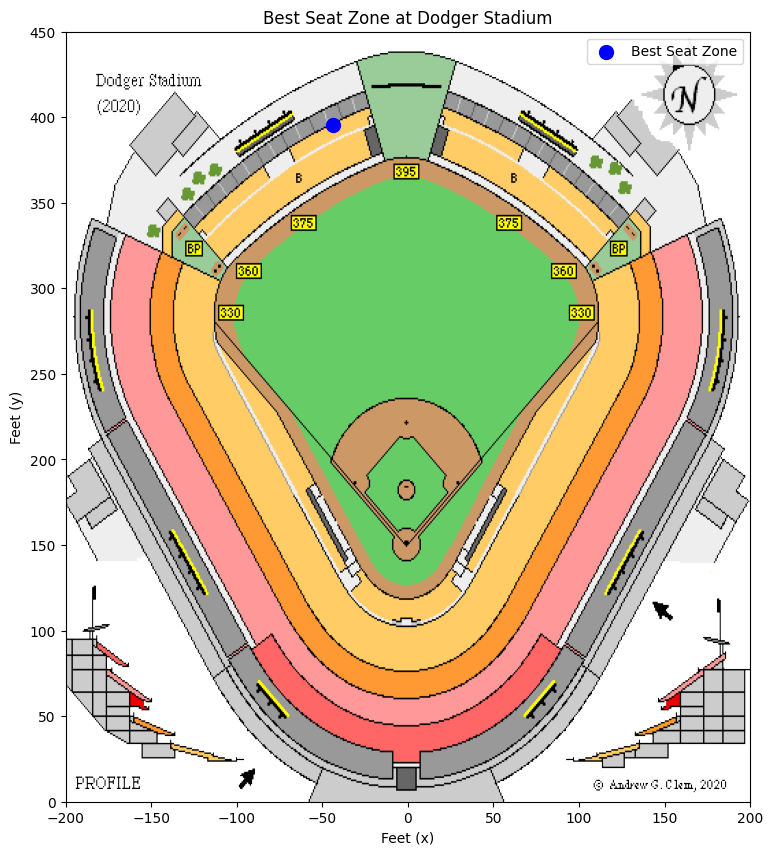

In [12]:
team1: str = input("Abbreviation of team 1 (Eg. PIT): ")
team2 = input("Abbreviation of team2 (Eg. SD): ")
stadium = input("Stadium Name: ")

print(f"Fetching home run data for {team1}...")
team1_hr = get_team_home_runs(team1)
print(f"Fetching home run data for {team2}...")
team2_hr = get_team_home_runs(team2)

team_home_runs = pd.concat([team1_hr, team2_hr], ignore_index=True)
plot_home_runs_on_stadium(stadium, team_home_runs)